In [1]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# try:
#   import GPUtil as GPU
#   GPUs = GPU.getGPUs()
#   device='/gpu:0'
# except:
#   device='/cpu:0'

# import os
# from google.colab import drive
# drive.mount('/content/drive')



# ##出現提示欄進行授權

# os.chdir('/content/drive/Shareddrives/專題') #切換該目錄
# os.listdir() #確認目錄內容
# !pip install zhon
from keras.models import load_model
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re 
import cv2
import keras
import keras.utils
from keras import utils as np_utils
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import cifar10 #匯入cifar10資料集
import numpy as np #匯入numpy模組
np.random.seed(10) #設定seed
from keras.utils import np_utils
from keras.models import Sequential  #匯入Sequential模組
from keras.preprocessing import sequence
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D  #匯入layers模組
from keras.layers import ZeroPadding2D,Activation  #匯入layers模組
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Input, Dense, concatenate,Embedding,Layer,Multiply 
import tensorflow as tf
from keras.layers.merge import Concatenate
from keras.layers.recurrent import LSTM
from sklearn.metrics import accuracy_score
from zhon.hanzi import punctuation
import jieba
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
from keras import metrics
from sklearn.metrics import mean_absolute_error
import random
np.random.seed(10)
from sklearn.utils import shuffle



In [2]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

def get_dataset_partitions_tf(dsx, dsy, ds_size):
    #assert (train_split + test_split + val_split) == 1
    
        # Specify seed to always have the same split distribution between runs
    dsx, dsy=shuffle(dsx, dsy)

    train_size = int(0.65* ds_size)
    val_size = int(0.1 * ds_size)
    

    train_dsx = dsx[:train_size]
    val_dsx = dsx[train_size:val_size]
    test_dsx = dsx[val_size:]
    
    train_dsy = dsy[:train_size]
    val_dsy = dsy[train_size:val_size]
    test_dsy = dsy[val_size:]
    
#     train_ds = ds.take(train_size)
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
    return train_dsx, val_dsx, test_dsx, train_dsy, val_dsy, test_dsy

X = pd.read_csv("concat_data_english.csv",encoding="utf-8")


viewcount=X["classifier_2"]
# viewcount=X.iloc[:,6:]


#photo

y = X.iloc[0:,1]
y = list(y)
pic_id = X.iloc[:,2:3]
# example of loading an image with the Keras API

##定義ImageDataGenerator
img_gen = ImageDataGenerator( featurewise_center=True,featurewise_std_normalization=True,rotation_range=10,width_shift_range=0.1,
                                            height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False,dtype=np.float32)
width = 480
height = 360
batch_size = 2


# load the image
# import torch

saveDir = './images1/'
# img_vec=torch.tensor([])
img_vec=[]
photo_combine=[]
for picid in pic_id['img']:
    #print(picid)
    if picid != 'img': 
        img = load_img(saveDir+str(picid)+'.jpg')
        
        #img = img.convert("RGBA")
        img = img.resize((32, 32))
        #顯示圖片
        #img.show()
        #將圖片轉換為陣列形式，元素為其畫素的亮度值
        img_vec.append(np.asarray(img, dtype=np.float32))


img_vec=np.array(img_vec)
    
x2_train, x2_test, y2_train, y2_test = train_test_split(img_vec, viewcount, test_size=0.35)
x2_train=np.array(x2_train)
x2_test=np.array(x2_test)
x2_train = x2_train.reshape(x2_train.shape[0],32,32,3).astype('float32')#可以不用轉
x2_test = x2_test.reshape(x2_test.shape[0],32,32,3).astype('float32')
y2_train=np.array(y2_train)
y2_test=np.array(y2_test)
x2_train_normalize=x2_train/255.0
x2_test_normalize=x2_test/255.0

x2_train_normalize=tf.convert_to_tensor(x2_train_normalize)
x2_test_normalize=tf.convert_to_tensor(x2_test_normalize)
     

#photo model
model_photo=Sequential()

model_photo.add(Conv2D(filters=32,  #隨機產生32個filter weight
                 kernel_size=(3,3), #濾鏡大小3X3
                 padding='same',  #設定卷積運算，產生的卷積影像大小相同
                 input_shape=(32,32,3),  #輸入影像32X32，RGB3原色
                 activation='relu')) #ReLU激活函數


model_photo.add(Dropout(0.25))  #每次迭代，隨機丟棄 25% 神經元

model_photo.add(MaxPooling2D(pool_size=(2, 2))) #將32X32影像，縮小成16X16的影像


model_photo.add(Conv2D(filters=64,  #隨機產生64個filter weight
                 kernel_size=(3,3), #濾鏡大小3X3
                 padding='same', #設定卷積運算，產生的卷積影像大小相同
                 activation='relu'))#ReLU激活函數

model_photo.add(Dropout(0.25)) #每次迭代，隨機丟棄 25% 神經元

model_photo.add(MaxPooling2D(pool_size=(2, 2)))  #將16X16影像，縮小成8X8的影像

model_photo.add(Flatten())  #池化層2的64個8X8影像轉為一維向量=>64X8X8=4096(個神經元)
model_photo.add(Dropout(0.25))#隨機丟棄 25% 神經元
model_photo.add(Dense(1, activation='softmax'))



# final_model = Model(model_photo.input,model_photo.output)




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

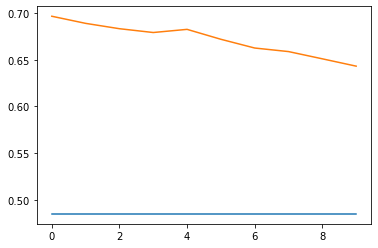

In [3]:
   
model_photo.summary()

model_photo.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
# 'sparse_categorical_crossentropy'


train_history = model_photo.fit(x2_train_normalize,y2_train, batch_size=64, epochs = 10, verbose=1,validation_data=(x2_test_normalize,y2_test))
y_pred = np.round(model_photo.predict(x2_test_normalize,steps=1))

# s=final_model.evaluate([x1_train, x2_train_normalize], sum_vector,verbose=1,steps=1)
# print("Accuracy of train:", s[1])
scores = model_photo.evaluate(x2_train_normalize, y2_train,verbose=1,steps=1)
# print("Accuracy:"+str(scores[1]))

# y2_test=np.argmax(y2_test, axis=1)

scores=model_photo.evaluate(x2_test_normalize,y2_test,verbose=1,steps=1)

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['loss'])

